In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dataset = torchvision.datasets.MNIST(
    root = '.',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

In [97]:
import math

## Model

In [401]:
class PowerPropLinearAuto(nn. Module):
  def __init__(self, in_size, out_size, alpha):
    super().__init__()
    self.in_size = in_size
    self.out_size = out_size
    bias = torch.Tensor(out_size)
    self.bias = nn.Parameter(bias)
    self.alpha = alpha

    super_weights = torch.Tensor(out_size, in_size)
    nn.init.kaiming_uniform_(super_weights, a=math.sqrt(5))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(super_weights)
    bound = 1 / math.sqrt(fan_in)
    nn.init.uniform_(self.bias, -bound, bound) 

    abs = torch.abs(super_weights)
    signs = torch.sign(super_weights)
    weights = torch.mul(signs, torch.pow(abs, 1/alpha))
    self.weights = nn.Parameter(weights)

  def forward(self, x):
    super_weights = torch.mul(torch.sign(self.weights), torch.pow(torch.abs(self.weights), self.alpha))
    w_times_x = torch.mm(x, super_weights.t())
    return torch.add(w_times_x, self.bias)

  def adjust_alpha(self, fast = False, cut = False, common_ratio = 1.5, common_diff = 0.1):
    super_weights = torch.mul(torch.sign(self.weights), torch.pow(torch.abs(self.weights), self.alpha))
    if fast and not cut:
      self.alpha = 1 + (self.alpha-1)*common_ratio # geometric increase
    elif cut:
      self.alpha = 1 + (self.alpha-1)/common_ratio # geometric decrease
    else :
      self.alpha = self.alpha + common_diff # linear increase

    abs = torch.abs(super_weights)
    signs = torch.sign(super_weights)
    weights = torch.mul(signs, torch.pow(abs, 1/self.alpha))  
    self.weights.data = weights

## Training

In [402]:
alpha = 1.25
epsilon = 0.001

In [403]:
model = nn.Sequential(
    PowerPropLinearAuto(784, 128, alpha),
    nn.ReLU(),
    PowerPropLinearAuto(128, 10, alpha)
)

In [404]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [405]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [406]:
def count_weights_in_range(weights, epsilon): # measures sparsity
  return np.sum(np.abs(weights.detach().numpy()) < epsilon)

Epoch 1/30, Train Loss: 0.5005, Test Loss: 0.2522, alpha: 1.2500


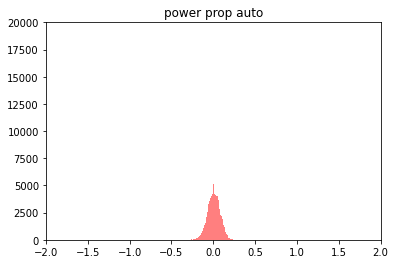

Epoch 2/30, Train Loss: 0.2249, Test Loss: 0.1897, alpha: 1.2500


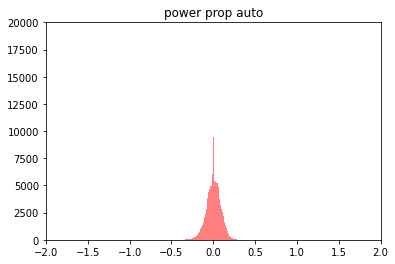

Epoch 3/30, Train Loss: 0.1702, Test Loss: 0.1490, alpha: 1.2500


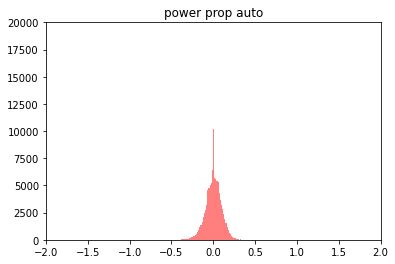

2734 0
Epoch 4/30, Train Loss: 0.1340, Test Loss: 0.1260, alpha: 1.3750


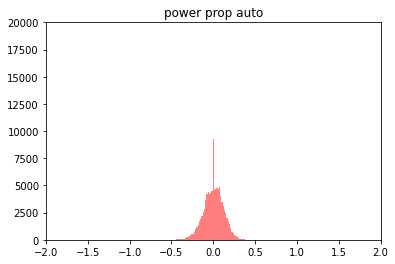

Epoch 5/30, Train Loss: 0.1111, Test Loss: 0.1108, alpha: 1.3750


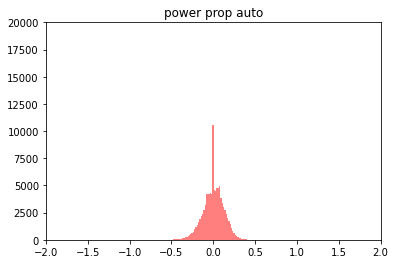

Epoch 6/30, Train Loss: 0.0934, Test Loss: 0.0999, alpha: 1.3750


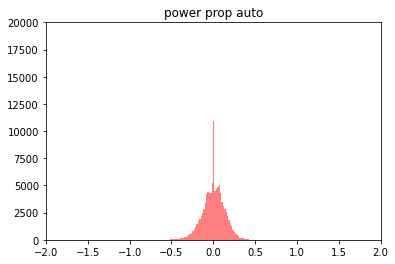

Epoch 7/30, Train Loss: 0.0799, Test Loss: 0.0905, alpha: 1.3750


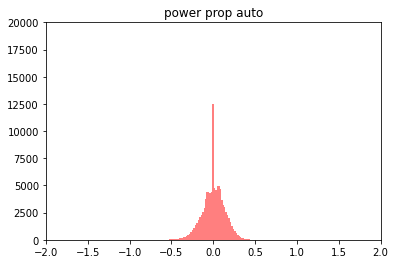

4432 2734
Epoch 8/30, Train Loss: 0.0679, Test Loss: 0.0901, alpha: 1.5625


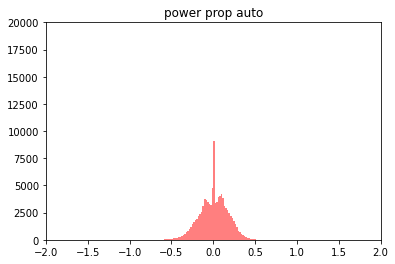

Epoch 9/30, Train Loss: 0.0601, Test Loss: 0.0809, alpha: 1.5625


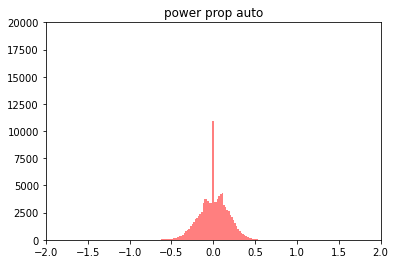

Epoch 10/30, Train Loss: 0.0527, Test Loss: 0.0788, alpha: 1.5625


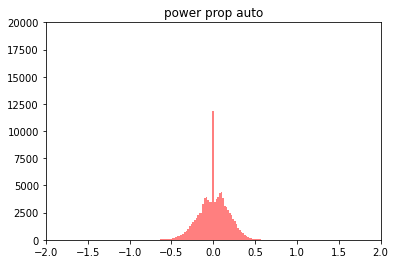

Epoch 11/30, Train Loss: 0.0477, Test Loss: 0.0752, alpha: 1.5625


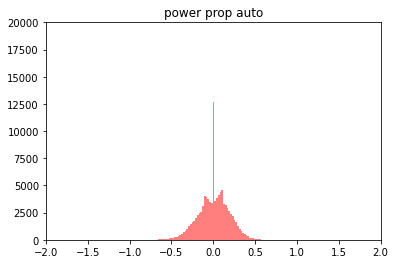

7078 4432
Epoch 12/30, Train Loss: 0.0414, Test Loss: 0.0755, alpha: 1.8438


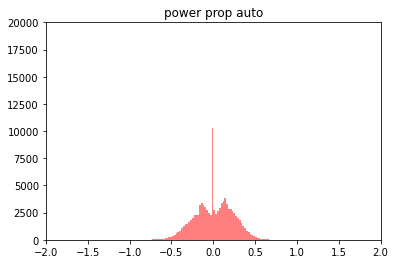

Epoch 13/30, Train Loss: 0.0368, Test Loss: 0.0737, alpha: 1.8438


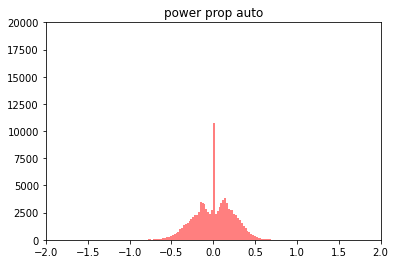

Epoch 14/30, Train Loss: 0.0331, Test Loss: 0.0746, alpha: 1.8438


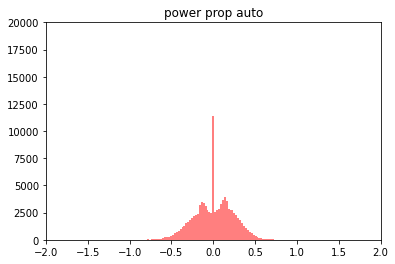

Epoch 15/30, Train Loss: 0.0301, Test Loss: 0.0789, alpha: 1.8438


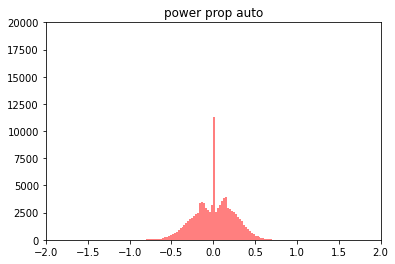

7447 7078
Epoch 16/30, Train Loss: 0.0263, Test Loss: 0.0748, alpha: 2.2656


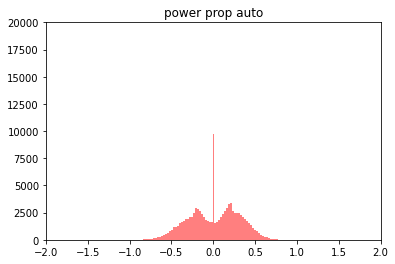

Epoch 17/30, Train Loss: 0.0231, Test Loss: 0.0753, alpha: 2.2656


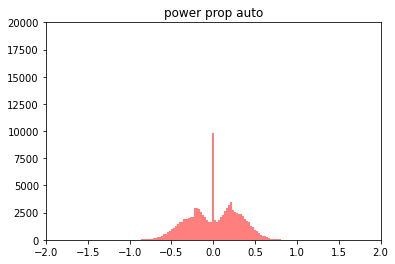

Epoch 18/30, Train Loss: 0.0206, Test Loss: 0.0790, alpha: 2.2656


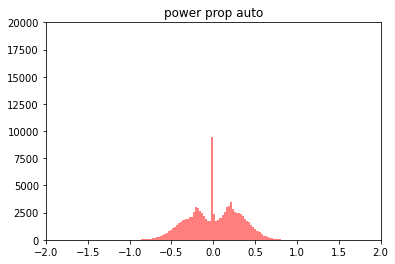

Epoch 19/30, Train Loss: 0.0182, Test Loss: 0.0767, alpha: 2.2656


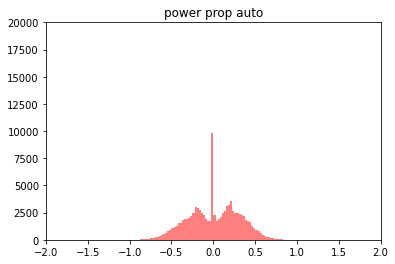

7044 7447
Epoch 20/30, Train Loss: 0.0164, Test Loss: 0.0807, alpha: 1.8438


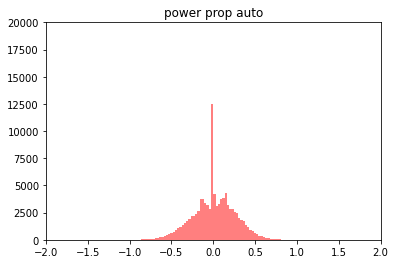

Epoch 21/30, Train Loss: 0.0148, Test Loss: 0.0768, alpha: 1.8438


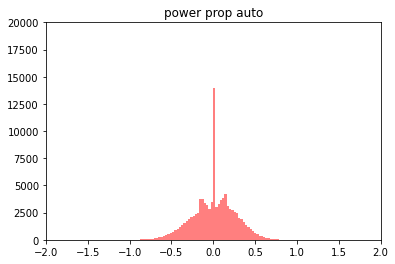

Epoch 22/30, Train Loss: 0.0128, Test Loss: 0.0812, alpha: 1.8438


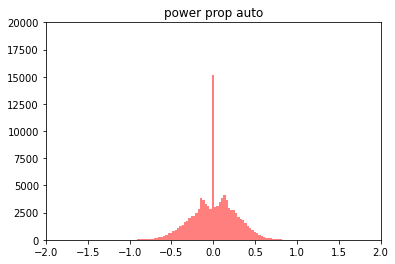

Epoch 23/30, Train Loss: 0.0112, Test Loss: 0.0833, alpha: 1.8438


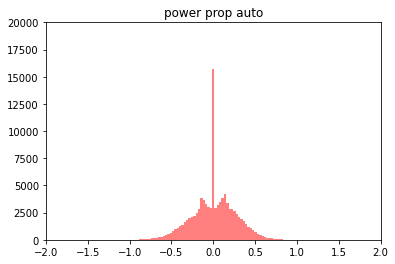

10485 7044
Epoch 24/30, Train Loss: 0.0096, Test Loss: 0.0811, alpha: 1.9438


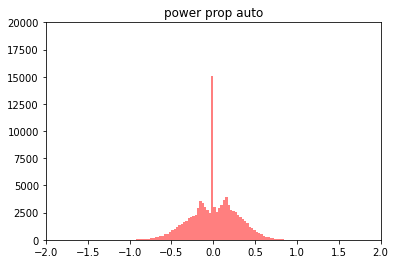

Epoch 25/30, Train Loss: 0.0086, Test Loss: 0.0876, alpha: 1.9438


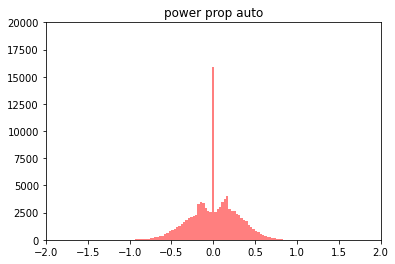

Epoch 26/30, Train Loss: 0.0077, Test Loss: 0.0870, alpha: 1.9438


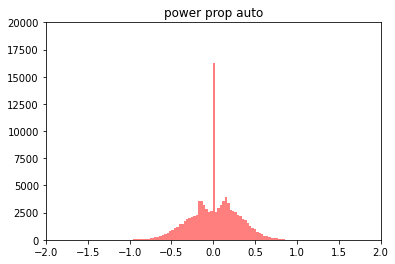

Epoch 27/30, Train Loss: 0.0068, Test Loss: 0.0882, alpha: 1.9438


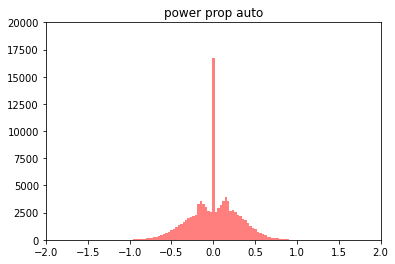

12632 10485
Epoch 28/30, Train Loss: 0.0056, Test Loss: 0.0925, alpha: 2.0438


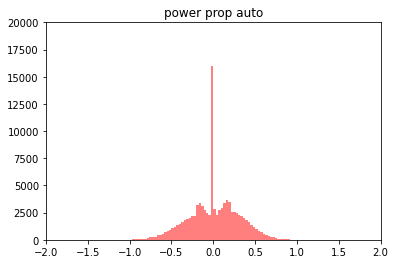

Epoch 29/30, Train Loss: 0.0050, Test Loss: 0.0944, alpha: 2.0438


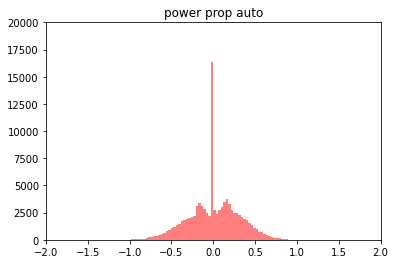

Epoch 30/30, Train Loss: 0.0043, Test Loss: 0.0954, alpha: 2.0438


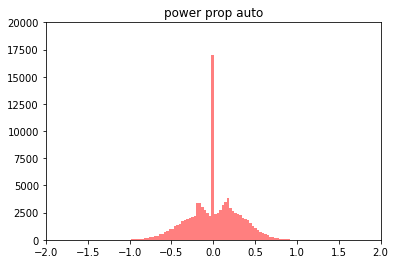

In [407]:
n_epochs = 30

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)
alphas = np.ones(n_epochs)
cnt = 0
old_sum = 0
new_sum = 0
fast = True

for it in range(n_epochs):
  train_loss = []

  
  with torch.no_grad():
    if cnt == 3:
        print(new_sum, old_sum)
        if new_sum >= old_sum :
            model[0].adjust_alpha(fast = fast, cut = False)
            model[2].adjust_alpha(fast = fast, cut = False)
        else:
            fast = False
            model[0].adjust_alpha(cut = True)
            model[2].adjust_alpha(cut = True)
        cnt = 0
        old_sum = new_sum
    else:
        if cnt==0:
          new_sum = 0 
        new_sum = max(new_sum, count_weights_in_range(model[0].weights, epsilon) + count_weights_in_range(model[2].weights, epsilon))
        cnt += 1

  alphas[it] = model[0].alpha

  for inputs, targets in train_loader:
    inputs = inputs.view(-1, 784)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  train_loss = np.mean(train_loss) 
  

  test_loss = []
  for inputs, targets in test_loader:
    inputs = inputs.view(-1, 784)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  train_losses[it] = train_loss
  test_losses[it] = test_loss
    
  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, alpha: {alphas[it]:.4f}')
  weights = np.concatenate((model[0].weights.cpu().detach().numpy().flatten(), model[2].weights.cpu().detach().numpy().flatten()))
  plt.hist(weights, bins=100, alpha=0.5, color = "red")
  plt.xlim([-2, 2])
  plt.ylim([0, 20000])
  plt.title("power prop auto")
  plt.show()

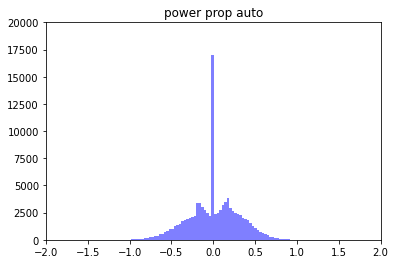

In [412]:
weights = np.concatenate((model[0].weights.cpu().detach().numpy().flatten(), model[2].weights.cpu().detach().numpy().flatten()))
plt.hist(weights, bins=100, alpha=0.5, color = "blue")
plt.xlim([-2, 2])
plt.ylim([0, 20000])
plt.title("power prop auto")
plt.show()

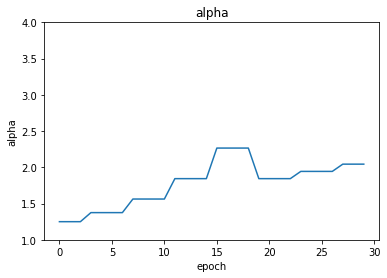

In [411]:
plt.plot(alphas)
plt.ylim([1, 4])
plt.xlabel("epoch")
plt.ylabel("alpha")
plt.title("alpha")
plt.show()